<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

fatal: destination path 'nn_hallucinations' already exists and is not an empty directory.


In [79]:
import time

import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets

In [80]:
BATCH_SIZE = 512
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1),  # Flatten.
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

In [81]:
class MaskedLinear(nn.Linear):
  """A Linear layer with masks that turn off some of the layer's weights."""

  def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', torch.ones((out_features, in_features)))

  def set_mask(self, mask):
    self.mask.data.copy_(mask)

  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)


class MADE(nn.Module):
  """Implementation of the Masked Autoencoder Distribution Estimator (MADE).

  MADE is a regular, fully-connected autoencoder with a connectivity pattern 
  that respects autoregressive constraints, i.e., for any ordering of the 
  inputs, each input is constructed only from the previous inputs. This property 
  allows MADE to model P(X) by decomposing it as the product p(x_i | x_{j<i}).
  Interestingly, this means that MADE can turn any regular autoencoder into a 
  powerful generative model.

  For full details, see the paper by Germain et al. (2015).
  """

  def __init__(self, input_dim, hidden_dims=None, n_masks=1):
    """Initializes a new MADE instance.
    
    Args:
      input_dim: The dimensionality of the input.
      hidden_dims: A list containing the number of units for each hidden layer.
      n_masks: The total number of distinct masks to use during training/eval.
    """
    super().__init__()
    self._input_dim = input_dim
    self._dims = [self._input_dim] + (hidden_dims or []) + [self._input_dim]
    self._n_masks = n_masks
    self._mask_seed = 0

    layers = []
    for i in range(len(self._dims) - 1):
      in_dim, out_dim = self._dims[i], self._dims[i + 1]
      layers.append(MaskedLinear(in_dim, out_dim))
      layers.append(nn.ReLU())
    layers[-1] = nn.Sigmoid()  # Output is binary. 
    self._net = nn.Sequential(*layers)

  def _sample_masks(self):
    """Samples a new set of autoregressive masks.

    Only 'self._n_masks' distinct sets of masks are sampled after which the mask
    sets are rotated through in the order in which they were sampled. In 
    principle, it's possible to generate the masks once and cache them. However,
    this can lead to memory issues for large 'self._n_masks' or models many
    parameters. Finally, sampling the masks is not that computationally 
    expensive. 

    Returns:
      A tuple of (masks, ordering). Ordering refers to the ordering of the 
        outputs since MADE is order agnostic.
    """
    rng = np.random.RandomState(seed=self._mask_seed % self._n_masks)
    self._mask_seed += 1

    # Sample connectivity patterns.
    conn = [rng.permutation(self._input_dim)]
    for i, dim in enumerate(self._dims[1:-1]):
      # NOTE(eugenhotaj): The dimensions in the paper are 1-indexed whereas 
      # arrays in Python are 0-indexed. Implementation adjusted accordingly. 
      low = 0 if i == 0 else np.min(conn[i - 1])
      high = self._input_dim - 1
      conn.append(rng.randint(low, high, size=dim))
    conn.append(np.copy(conn[0]))

    # Create masks.
    masks = [conn[i - 1][None, :] <= conn[i][:, None] 
             for i in range(1, len(conn) - 1 )]
    masks.append(conn[-2][None, :] < conn[-1][:, None])

    return [torch.from_numpy(mask.astype(np.uint8)) for mask in masks], conn[-1]

  def _forward(self, x, masks): 
    layers = [
      layer for layer in self._net.modules() if isinstance(layer, MaskedLinear)]
    for layer, mask in zip(layers, masks):
      layer.set_mask(mask)
    return self._net(x)

  def forward(self, x):
    """Computes a forward pass."""
    masks, _ = self._sample_masks()
    return self._forward(x, masks)

  def sample(self, conditioned_on=None):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
      if conditioned_on is None:
        device = next(self.parameters()).device
        conditioned_on = (torch.ones((1, self._input_dim)) * - 1).to(device)
      else:
        conditioned_on = conditioned_on.clone()

      masks, ordering = self._sample_masks()
      ordering = np.argsort(ordering)
      for dim in ordering:
        out = self._forward(conditioned_on, masks)[:, dim]
        out = distributions.Bernoulli(probs=out).sample()
        conditioned_on[:, dim] = torch.where(
            conditioned_on[:, dim] < 0, out, conditioned_on[:, dim])
      return conditioned_on

In [89]:
INPUT_SIZE = 784
HIDDEN_SIZES = [8000]
N_MASKS = 1
N_EPOCHS = 50

model = MADE(INPUT_SIZE, HIDDEN_SIZES, N_MASKS).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda x, y, preds: bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader,
    eval_loader=test_loader,
    device=colab_utils.get_device())

[1 | 3676]: train_loss=171.70112907714844 eval_loss=116.22085223388672
[2 | 3688]: train_loss=108.86370039876302 eval_loss=102.54329061279297
[3 | 3731]: train_loss=100.75758192545572 eval_loss=97.8593831665039
[4 | 3674]: train_loss=97.12816224772135 eval_loss=95.1466417602539
[5 | 3764]: train_loss=94.96368619791667 eval_loss=93.45696756591796
[6 | 3819]: train_loss=93.42262976074218 eval_loss=92.13479854736327
[7 | 3746]: train_loss=92.23209170735677 eval_loss=91.31476876220704
[8 | 3739]: train_loss=91.3007548828125 eval_loss=90.55763106689453
[9 | 3802]: train_loss=90.52569490559895 eval_loss=89.86064848632813
[10 | 3739]: train_loss=89.80922435302735 eval_loss=89.46402545166016
[11 | 3740]: train_loss=89.2541927734375 eval_loss=88.7459870727539
[12 | 3702]: train_loss=88.76606447347005 eval_loss=88.37559586181641
[13 | 3755]: train_loss=88.28206087239583 eval_loss=88.15163110351563
[14 | 3736]: train_loss=87.93153051757812 eval_loss=87.70669146728515
[15 | 3786]: train_loss=87.64

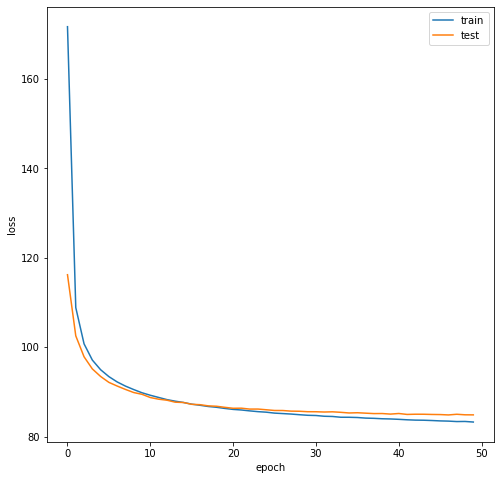

In [90]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [91]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))


def sample(model):
  colab_utils.imshow(model.sample().reshape(28, 28))


def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

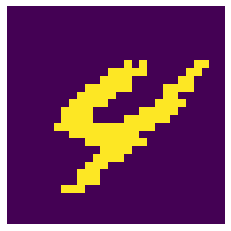

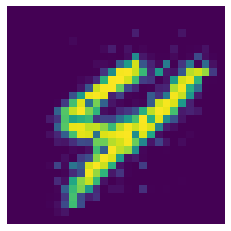

In [92]:
show_random(model, test_loader.dataset)

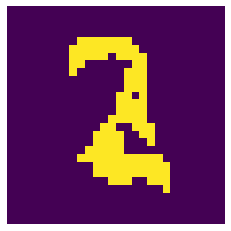

In [93]:
sample(model)

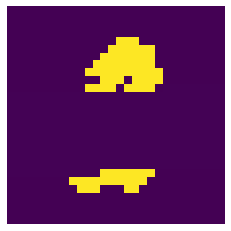

Conditional Samples:


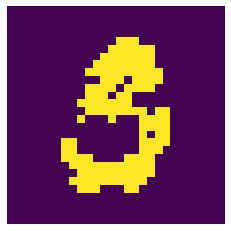

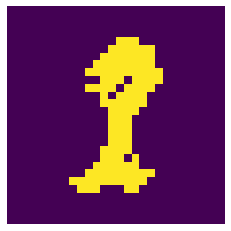

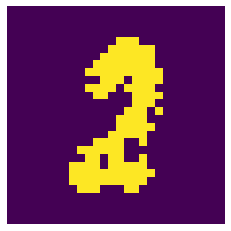

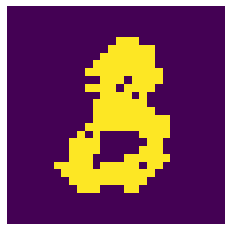

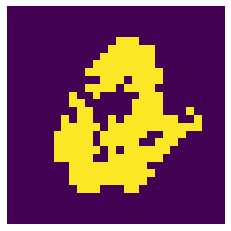

In [97]:
conditional_sample_random(model, test_loader.dataset)